<a href="https://colab.research.google.com/github/Gasspire/AppuntiUni/blob/main/Speaker_Recognition_Validazione.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import shutil
import numpy as np

import tensorflow as tf
import keras

from pathlib import Path
from IPython.display import display, Audio

#Setup di tutte le librerie necessarie e del modello di deep learning

In [8]:
!kaggle datasets download -d kongaevans/speaker-recognition-dataset
!unzip -qq speaker-recognition-dataset.zip
#Download del dataset da kaggle

Dataset URL: https://www.kaggle.com/datasets/kongaevans/speaker-recognition-dataset
License(s): unknown
100% 230M/231M [00:12<00:00, 18.2MB/s]
100% 231M/231M [00:12<00:00, 19.6MB/s]


In [9]:
!unzip -qq Davide_Petronio_Petronio.zip
#unzip del file con i miei audio nello stesso formato in cui sono quelli del dataset

In [10]:
DATASET_ROOT = "16000_pcm_speeches"

AUDIO_SUBFOLDER = "audio"
NOISE_SUBFOLDER = "noise"

DATASET_AUDIO_PATH = os.path.join(DATASET_ROOT, AUDIO_SUBFOLDER)
DATASET_NOISE_PATH = os.path.join(DATASET_ROOT, NOISE_SUBFOLDER)

#Percentuale di dati che verranno utillizzati come test set
VALID_SPLIT = 0.1

#Semplice seed di shuffle, cambiarlo non camiberebbe molto
SHUFFLE_SEED = 43

#Separiamo un ulteriore parte per testarlo alla fine
TEST_SPLIT = 0.2

SAMPLING_RATE = 16000

#Valore del rumore
SCALE = 0.5

#Numero di campioni per set
BATCH_SIZE = 128
#L'Epoch rappresenta un ciclo completo di addestramento su tutto il dataset. Se è uguale a 1 allora questo vedrà i dati solo una volta
EPOCHS = 1


In [11]:
for folder in os.listdir(DATASET_ROOT):
    if os.path.isdir(os.path.join(DATASET_ROOT, folder)):
        if folder in [AUDIO_SUBFOLDER, NOISE_SUBFOLDER]:
            continue
        elif folder in ["other", "_background_noise_"]:
            shutil.move(
                os.path.join(DATASET_ROOT, folder),
                os.path.join(DATASET_NOISE_PATH, folder),
            )
        else:
            shutil.move(
                os.path.join(DATASET_ROOT, folder),
                os.path.join(DATASET_AUDIO_PATH, folder),
            )

#Smistamento degli audio e dei rumori

In [12]:
noise_paths = [] #Prendiamo tutta la lista degli audio
for subdir in os.listdir(DATASET_NOISE_PATH):
    subdir_path = Path(DATASET_NOISE_PATH) / subdir
    if os.path.isdir(subdir_path):
        noise_paths += [
            os.path.join(subdir_path, filepath)
            for filepath in os.listdir(subdir_path)
            if filepath.endswith(".wav")
        ]
if not noise_paths:
    raise RuntimeError(f"Non sono stati trovati audio in {DATASET_NOISE_PATH}")
print(
    "Trovati {} files in {} directories".format(
        len(noise_paths), len(os.listdir(DATASET_NOISE_PATH))
    )
)

Trovati 6 files in 2 directories


In [13]:
command = (
    "for dir in `ls -1 " + DATASET_NOISE_PATH + "`; do "
    "for file in `ls -1 " + DATASET_NOISE_PATH + "/$dir/*.wav`; do "
    "sample_rate=`ffprobe -hide_banner -loglevel panic -show_streams "
    "$file | grep sample_rate | cut -f2 -d=`; "
    "if [ $sample_rate -ne 16000 ]; then "
    "ffmpeg -hide_banner -loglevel panic -y "
    "-i $file -ar 16000 temp.wav; "
    "mv temp.wav $file; "
    "fi; done; done"
)
os.system(command)


# Split noise into chunks of 16,000 steps each
def load_noise_sample(path):
    sample, sampling_rate = tf.audio.decode_wav(
        tf.io.read_file(path), desired_channels=1
    )
    if sampling_rate == SAMPLING_RATE:
        # Number of slices of 16000 each that can be generated from the noise sample
        slices = int(sample.shape[0] / SAMPLING_RATE)
        sample = tf.split(sample[: slices * SAMPLING_RATE], slices)
        return sample
    else:
        print("Sampling rate per {} è errato. Verrà ignorato".format(path))
        return None


noises = []
for path in noise_paths:
    sample = load_noise_sample(path)
    if sample:
        noises.extend(sample)
noises = tf.stack(noises)

print(
    "{} file di rumore sono stati divisi in {} samples dove ognuno è lungo {} sec.".format(
        len(noise_paths), noises.shape[0], noises.shape[1] // SAMPLING_RATE
    )
)

6 file di rumore sono stati divisi in 354 samples dove ognuno è lungo 1 sec.


In [14]:

def paths_and_labels_to_dataset(audio_paths, labels): #prende la lista di audio e le targhette e crea un dataset tensorflow
    """Constructs a dataset of audios and labels."""
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(
        lambda x: path_to_audio(x), num_parallel_calls=tf.data.AUTOTUNE
    )
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))

def predict_with_threshold(audio_batch, threshold=0.5):
  predictions = model.predict(audio_batch)
  predicted_labels = np.argmax(predictions, axis=1)
  # Applica il threshold alle probabilità predette
  predicted_probabilities = np.max(predictions, axis=1)
  predicted_labels[predicted_probabilities < threshold] = -1  # -1 per "altro"
  return predicted_labels


def path_to_audio(path):#questa funzione legge e decodifica un file audio nel path specificato
    """Reads and decodes an audio file."""
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, SAMPLING_RATE)
    return audio


def add_noise(audio, noises=None, scale=0.5):#Aggiungiamo del rumore ai campioni audio
    if noises is not None:
        tf_rnd = tf.random.uniform(
            (tf.shape(audio)[0],), 0, noises.shape[0], dtype=tf.int32
        )
        noise = tf.gather(noises, tf_rnd, axis=0)

        prop = tf.math.reduce_max(audio, axis=1) / tf.math.reduce_max(noise, axis=1)
        prop = tf.repeat(tf.expand_dims(prop, axis=1), tf.shape(audio)[1], axis=1)

        audio = audio + noise * prop * scale

    return audio



#Facciamo la trasformata di fourier
def audio_to_fft(audio):
    audio = tf.squeeze(audio, axis=-1)
    fft = tf.signal.fft(
        tf.cast(tf.complex(real=audio, imag=tf.zeros_like(audio)), tf.complex64)
    )
    fft = tf.expand_dims(fft, axis=-1)

    return tf.math.abs(fft[:, : (audio.shape[1] // 2), :])



class_names = os.listdir(DATASET_AUDIO_PATH)# costruiamo una lista di nomi che saranno usati come label
print(
    "Nomi: {}".format(
        class_names,
    )
)

#Vengono create due liste, audio_paths e labels
#per memorizzare i percorsi dei file audio e le corrispondenti etichette facendo l'associazione audio label.
audio_paths = []
labels = []
for label, name in enumerate(class_names):
    print(
        "Sto processando: {}".format(
            name,
        )
    )
    dir_path = Path(DATASET_AUDIO_PATH) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    audio_paths += speaker_sample_paths
    labels += [label] * len(speaker_sample_paths)

print(
    "Trovati {} files appartenenti a {} classi.".format(len(audio_paths), len(class_names))
)

# Shuffle per evitare bias
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(audio_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(labels)

# Split into training and validation
num_val_samples = int(VALID_SPLIT * len(audio_paths))
num_test_samples = int(TEST_SPLIT * len(audio_paths))
num_train_samples = len(audio_paths) - num_val_samples - num_test_samples

print("Uso {} files per il training set.".format(num_train_samples))
train_audio_paths = audio_paths[:num_train_samples]
train_labels = labels[:num_train_samples]

print("Uso {} files per il validation set.".format(num_val_samples))
valid_audio_paths = audio_paths[num_train_samples : num_train_samples + num_val_samples]
valid_labels = labels[num_train_samples : num_train_samples + num_val_samples]

print("Uso {} files per il test set.".format(num_test_samples))
test_audio_paths = audio_paths[num_train_samples + num_val_samples:]
test_labels = labels[num_train_samples + num_val_samples:]

#Creazione di due dataset tensorflow, uno per il train e uno per il validation
train_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels)
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

test_ds = paths_and_labels_to_dataset(test_audio_paths, test_labels)
test_ds = test_ds.shuffle(buffer_size=32 * 8, seed=SHUFFLE_SEED).batch(32)

valid_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
valid_ds = valid_ds.shuffle(buffer_size=32 * 8, seed=SHUFFLE_SEED).batch(32)


# Aggiungiamo il rumore
train_ds = train_ds.map(
    lambda x, y: (add_noise(x, noises, scale=SCALE), y),
    num_parallel_calls=tf.data.AUTOTUNE,
)

#Facciamo la trasformata di fourier per entrambi i dataset
train_ds = train_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

valid_ds = valid_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)


Nomi: ['Magaret_Tarcher', 'Jens_Stoltenberg', 'Nelson_Mandela', 'Davide_Petronio_Petronio', 'Julia_Gillard', 'Benjamin_Netanyau']
Sto processando: Magaret_Tarcher
Sto processando: Jens_Stoltenberg
Sto processando: Nelson_Mandela
Sto processando: Davide_Petronio_Petronio
Sto processando: Julia_Gillard
Sto processando: Benjamin_Netanyau
Trovati 9041 files appartenenti a 6 classi.
Uso 6329 files per il training set.
Uso 904 files per il validation set.
Uso 1808 files per il test set.


In [15]:
def residual_block(x, filters, conv_num=3, activation="relu"):
#Questa funzione crea un blocco residuo che è una componente fondamentale per le reti neurali
#X rappresenta l'input del blocco, filters rappresenta il numero di filtri da utilizzare negli strati di convoluzione
#conv_num il numero di strati, activation la funzione di attivazione
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_classes):
#funzione che definisce la struttura complessiva del modello
#input_shape è la forma degli input, num_classes è il numero di classi da riconoscere
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)


model = build_model((SAMPLING_RATE // 2, 1), len(class_names))

model.summary()

# Compiliamo il modello
model.compile(
    optimizer="Adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model_save_filename = "model.keras"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 8000, 1)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 8000, 16)       │             64 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 8000, 16)       │              0 │ conv1d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 8000, 16)       │            784 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 8000, 16)       │             32 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 8000, 16)       │              0 │ conv1d_2[0][0],        │
│                           │                        │                │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 8000, 16)       │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 4000, 16)       │              0 │ activation_1[0][0]     │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 4000, 32)       │          1,568 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 4000, 32)       │              0 │ conv1d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 4000, 32)       │          3,104 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 4000, 32)       │            544 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 4000, 32)       │              0 │ conv1d_5[0][0],        │
│                           │                        │                │ conv1d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 4000, 32)       │              0 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 2000, 32)       │              0 │ activation_3[0][0]     │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_7 (Conv1D)         │ (None, 2000, 64)       │          6,208 │ max_pooling1d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 2000, 64)       │              0 │ conv1d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_8 (Conv1D)    

 Total params: 3,088,726 (11.78 MB)

 Trainable params: 3,088,726 (11.78 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb],
)

50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.4246 - loss: 3.1484 - val_accuracy: 0.8673 - val_loss: 0.4490


Valutazione con il Train test che è stato appositamente tenuto da parte

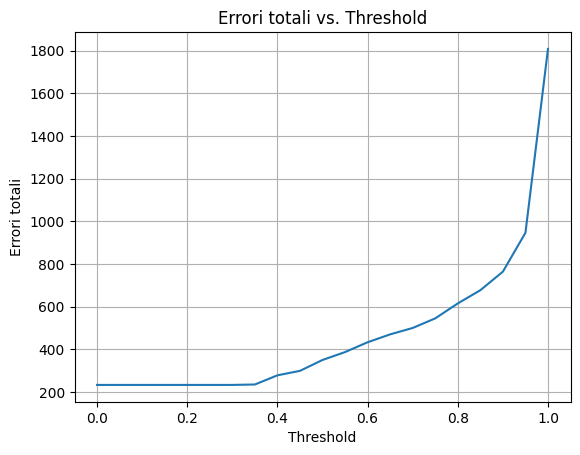

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def predict_with_threshold(audio_batch, threshold=0.5):
  predictions = model.predict(audio_batch, verbose=0)
  predicted_labels = np.argmax(predictions, axis=1)
  predicted_probabilities = np.max(predictions, axis=1)
  predicted_labels[predicted_probabilities < threshold] = -1  # -1 per "altro"
  return predicted_labels

# Lista di threshold da testare
thresholds = np.arange(0, 1.05, 0.05)

# Lista per memorizzare gli errori totali per ogni threshold
total_errors_list = []

for threshold in thresholds:
  y_true = []
  y_pred = []

  for audio_batch, label_batch in test_ds:
    predicted_labels = predict_with_threshold(audio_batch, threshold)
    y_true.extend(label_batch.numpy())
    y_pred.extend(predicted_labels)

  # Calcola la matrice di confusione
  all_labels = list(range(len(class_names))) + [-1]
  cm = confusion_matrix(y_true, y_pred, labels=all_labels)

  # Calcola gli errori totali
  total_samples = np.sum(cm)
  total_errors = total_samples - np.trace(cm)
  total_errors_list.append(total_errors)

# Crea il grafico
plt.plot(thresholds, total_errors_list)
plt.xlabel("Threshold")
plt.ylabel("Errori totali")
plt.title("Errori totali vs. Threshold")
plt.grid(True)
plt.show()

Cosa succede se si passa un audio creato da un IA?

In [17]:
from google.colab import files
import librosa
import numpy as np
import tensorflow as tf  # Import tf.shape

uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Carica l'audio e converti in mono
audio, sr = librosa.load(filename, sr=SAMPLING_RATE, mono=True)

display(Audio(audio, rate=sr))

# Dividi l'audio in segmenti di 1 secondo
segment_length = SAMPLING_RATE  # 1 secondo
segments = [audio[i:i + segment_length] for i in range(0, len(audio), segment_length)]

# Predizioni per ogni segmento
predictions = []
probabilities = [] # Lista per memorizzare le probabilità

for segment in segments:
    # Se il segmento è più corto di 1 secondo, aggiungi padding di zeri
    if len(segment) < segment_length:
        segment = np.pad(segment, (0, segment_length - len(segment)), 'constant')

    # Applica la FFT (con correzione per l'errore)
    fft = audio_to_fft(np.expand_dims(np.expand_dims(segment, axis=0), axis=-1))

    # Ottieni la forma del tensore fft
    fft_shape = tf.shape(fft)

    # Imposta la forma esplicitamente
    fft = tf.reshape(fft, [fft_shape[0], fft_shape[1], fft_shape[2]])

    # Esegui la predizione
    y_pred = model.predict(fft, verbose=0)
    predicted_speaker = class_names[np.argmax(y_pred)]
    predictions.append(predicted_speaker)

    probability = np.max(y_pred) # Ottieni la probabilità massima
    probabilities.append(probability)


# Aggregazione (opzionale):
from collections import Counter
most_frequent_speaker = Counter(predictions).most_common(1)[0][0]
average_probability = np.mean(probabilities) # Calcola la probabilità media

print(f"Parlante più frequente nell'audio: {most_frequent_speaker}")
print(f"Grado di somiglianza medio: {average_probability:.2f}") # Stampa con 2 decimali

Saving aivoicedub.wav to aivoicedub.wav


Parlante più frequente nell'audio: Davide_Petronio_Petronio
Grado di somiglianza medio: 0.90


Altra prova, cosa succede se provo a passare un audio con naso tappato?

In [18]:
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Carica l'audio e converti in mono
audio, sr = librosa.load(filename, sr=SAMPLING_RATE, mono=True)

display(Audio(audio, rate=sr))

# Dividi l'audio in segmenti di 1 secondo
segment_length = SAMPLING_RATE  # 1 secondo
segments = [audio[i:i + segment_length] for i in range(0, len(audio), segment_length)]

# Predizioni per ogni segmento
predictions = []
probabilities = [] # Lista per memorizzare le probabilità

for segment in segments:
    # Se il segmento è più corto di 1 secondo, aggiungi padding di zeri
    if len(segment) < segment_length:
        segment = np.pad(segment, (0, segment_length - len(segment)), 'constant')

    # Applica la FFT (con correzione per l'errore)
    fft = audio_to_fft(np.expand_dims(np.expand_dims(segment, axis=0), axis=-1))

    # Ottieni la forma del tensore fft
    fft_shape = tf.shape(fft)

    # Imposta la forma esplicitamente
    fft = tf.reshape(fft, [fft_shape[0], fft_shape[1], fft_shape[2]])

    # Esegui la predizione
    y_pred = model.predict(fft, verbose=0)
    predicted_speaker = class_names[np.argmax(y_pred)]
    predictions.append(predicted_speaker)

    probability = np.max(y_pred) # Ottieni la probabilità massima
    probabilities.append(probability)


# Aggregazione (opzionale):
from collections import Counter
most_frequent_speaker = Counter(predictions).most_common(1)[0][0]
average_probability = np.mean(probabilities) # Calcola la probabilità media

print(f"Parlante più frequente nell'audio: {most_frequent_speaker}")
print(f"Grado di somiglianza medio: {average_probability:.2f}") # Stampa con 2 decimali

Saving Nasotappato.wav to Nasotappato.wav


Parlante più frequente nell'audio: Davide_Petronio_Petronio
Grado di somiglianza medio: 0.61


In [19]:
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Carica l'audio e converti in mono
audio, sr = librosa.load(filename, sr=SAMPLING_RATE, mono=True)

display(Audio(audio, rate=sr))

# Dividi l'audio in segmenti di 1 secondo
segment_length = SAMPLING_RATE  # 1 secondo
segments = [audio[i:i + segment_length] for i in range(0, len(audio), segment_length)]

# Predizioni per ogni segmento
predictions = []
probabilities = [] # Lista per memorizzare le probabilità

for segment in segments:
    # Se il segmento è più corto di 1 secondo, aggiungi padding di zeri
    if len(segment) < segment_length:
        segment = np.pad(segment, (0, segment_length - len(segment)), 'constant')

    # Applica la FFT (con correzione per l'errore)
    fft = audio_to_fft(np.expand_dims(np.expand_dims(segment, axis=0), axis=-1))

    # Ottieni la forma del tensore fft
    fft_shape = tf.shape(fft)

    # Imposta la forma esplicitamente
    fft = tf.reshape(fft, [fft_shape[0], fft_shape[1], fft_shape[2]])

    # Esegui la predizione
    y_pred = model.predict(fft, verbose=0)
    predicted_speaker = class_names[np.argmax(y_pred)]
    predictions.append(predicted_speaker)

    probability = np.max(y_pred) # Ottieni la probabilità massima
    probabilities.append(probability)


# Aggregazione (opzionale):
from collections import Counter
most_frequent_speaker = Counter(predictions).most_common(1)[0][0]
average_probability = np.mean(probabilities) # Calcola la probabilità media

print(f"Parlante più frequente nell'audio: {most_frequent_speaker}")
print(f"Grado di somiglianza medio: {average_probability:.2f}") # Stampa con 2 decimali

Saving dopp.wav to dopp.wav


Parlante più frequente nell'audio: Davide_Petronio_Petronio
Grado di somiglianza medio: 0.79
